In [65]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [42]:
ticker = "AAPL"
df = yf.download(ticker, "2020-01-01")

C:\Users\WINDOWS\AppData\Local\Temp\ipykernel_12508\3916021105.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, "2020-01-01")
[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

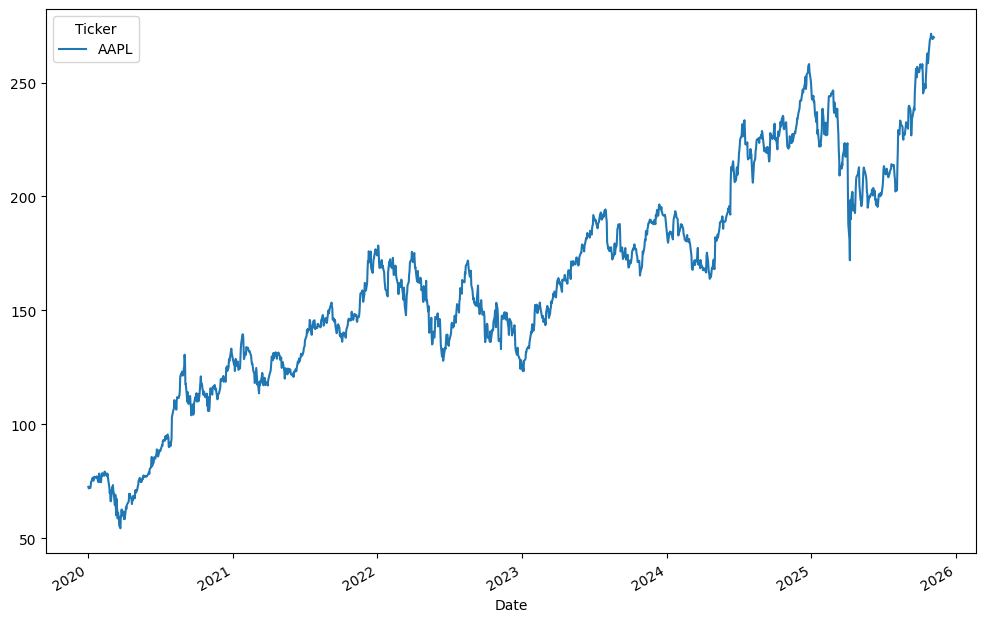

In [43]:
df['Close'].plot(figsize=(12, 8))

In [44]:
scaler = StandardScaler()

df['Close'] = scaler.fit_transform(df['Close'])

In [45]:
df['Close']

Ticker,AAPL
Date,
2020-01-02,-1.903350
2020-01-03,-1.918297
2020-01-06,-1.906165
2020-01-07,-1.913383
2020-01-08,-1.888812
...,...
2025-10-31,2.289699
2025-11-03,2.261721
2025-11-04,2.282705


In [46]:
seq_lenght = 30
col_close = df['Close']
data = []

for i in range(len(df)-seq_lenght):
    data.append(col_close[i:i+seq_lenght])

data = np.array(data)


In [47]:
data

array([[[-1.90334956],
        [-1.91829713],
        [-1.90616534],
        ...,
        [-1.80087716],
        [-1.76193267],
        [-1.77388788]],

       [[-1.91829713],
        [-1.90616534],
        [-1.91338274],
        ...,
        [-1.76193267],
        [-1.77388788],
        [-1.77347747]],

       [[-1.90616534],
        [-1.91338274],
        [-1.88881241],
        ...,
        [-1.77388788],
        [-1.77347747],
        [-1.80400713]],

       ...,

       [[ 1.95184985],
        [ 1.90691644],
        [ 2.00356583],
        ...,
        [ 2.31152993],
        [ 2.28969905],
        [ 2.26172142]],

       [[ 1.90691644],
        [ 2.00356583],
        [ 1.97368105],
        ...,
        [ 2.28969905],
        [ 2.26172142],
        [ 2.28270497]],

       [[ 2.00356583],
        [ 1.97368105],
        [ 1.95184985],
        ...,
        [ 2.26172142],
        [ 2.28270497],
        [ 2.2848246 ]]], shape=(1441, 30, 1))

In [48]:
train_size = int(0.8 * len(data))

X_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device)
X_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)

In [49]:
class PredictionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])

        return out

In [50]:
model = PredictionModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device)

In [57]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [58]:
num_epochs = 200

for i in range(num_epochs):
    y_train_pred = model(X_train)

    loss = criterion(y_train_pred, y_train)

    if i % 25 == 0:
        print(i, loss.item())
    
    optimizer.zero_grad()
    
    loss.backward()

    optimizer.step()

0 0.013606379739940166
25 0.014934576116502285
50 0.008548561483621597
75 0.006578337401151657
100 0.00597037049010396
125 0.005574355833232403
150 0.005225472152233124
175 0.004899757914245129


In [59]:
model.eval()

y_test_pred = model(X_test)

y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

In [67]:
train_rmse = root_mean_squared_error(y_train[:, 0], y_train_pred[:, 0])
test_rmse = root_mean_squared_error(y_test[:, 0], y_test_pred[:, 0])

train_mse = mean_squared_error(y_train[:, 0], y_train_pred[:, 0])
test_mse = mean_squared_error(y_test[:, 0], y_test_pred[:, 0])

train_mae = mean_absolute_error(y_train[:, 0], y_train_pred[:, 0])
test_mae = mean_absolute_error(y_test[:, 0], y_test_pred[:, 0])

train_mape = mean_absolute_percentage_error(y_train[:, 0], y_train_pred[:, 0])
test_mape = mean_absolute_percentage_error(y_test[:, 0], y_test_pred[:, 0])

In [72]:
print("                 ---METRICS---       ")
print(f"RMSE Train: {train_rmse}, RMSE Test: {test_rmse}\n")
print(f"MSE Train: {train_mse}, MSE Test: {test_mse}\n")
print(f"MAE Train: {train_mae}, MAE Test: {test_mae}\n")
print(f"MAPE Train: {train_mape}, MAPE Test: {test_mape}\n")

                 ---METRICS---       
RMSE Train: 3.203679323196411, RMSE Test: 7.859784126281738

MSE Train: 10.263561248779297, MSE Test: 61.776206970214844

MAE Train: 2.444727659225464, MAE Test: 5.684206485748291

MAPE Train: 0.017572833225131035, MAPE Test: 0.024439508095383644



7.859784126281738

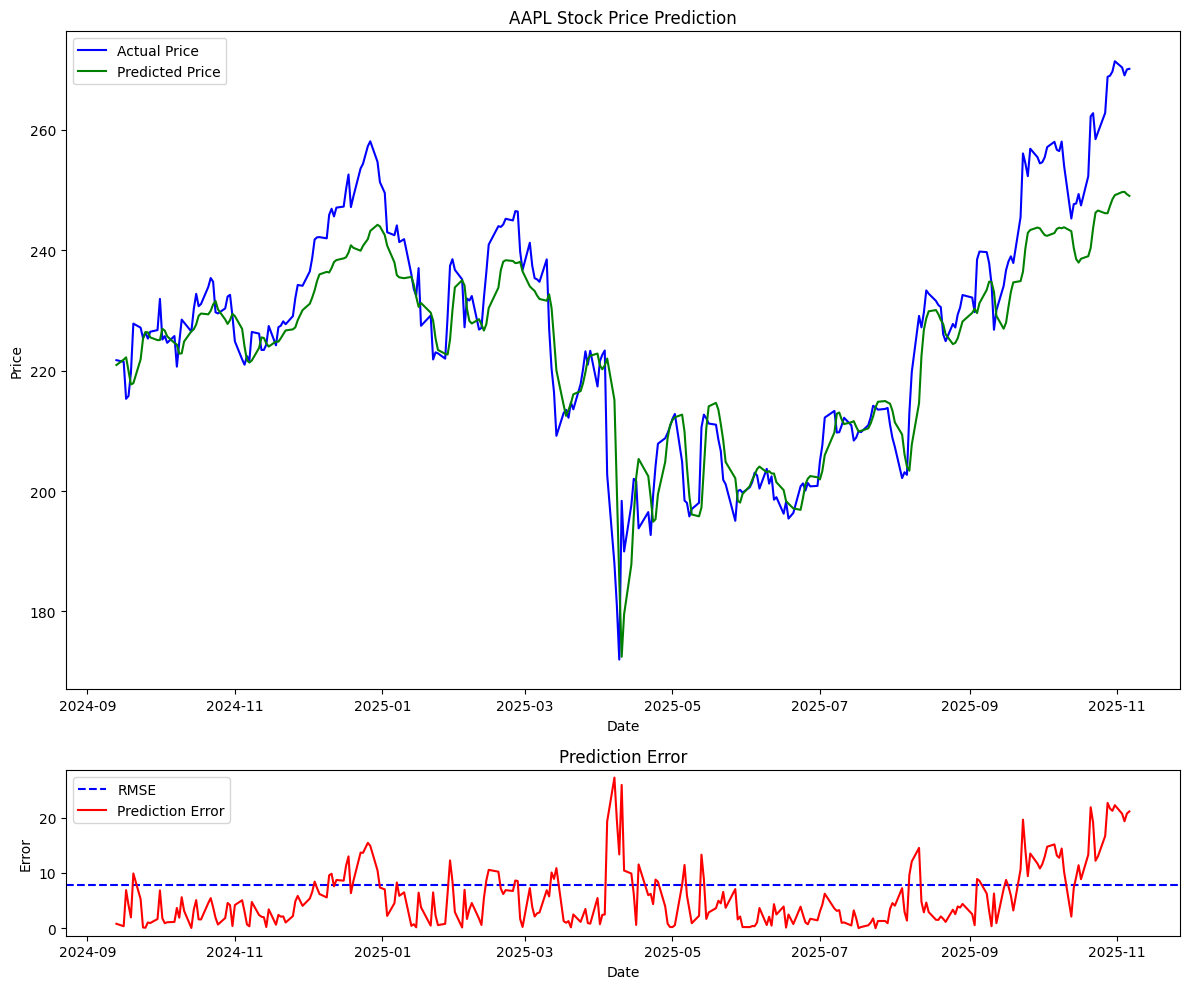

In [64]:
fig = plt.figure(figsize=(12, 10))

gs = fig.add_gridspec(4, 1)

ax1 = fig.add_subplot(gs[:3, 0])
ax1.plot(df.iloc[-len(y_test):].index, y_test, color='blue', label = "Actual Price")
ax1.plot(df.iloc[-len(y_test):].index, y_test_pred, color='green', label = "Predicted Price")
ax1.legend()
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel('Price')

ax2 = fig.add_subplot(gs[3, 0])
ax2.axhline(test_rmse, color='blue', linestyle='--', label='RMSE')
ax2.plot(df[-len(y_test):].index, abs(y_test-y_test_pred), 'r', label="Prediction Error")
ax2.legend()
plt.title('Prediction Error')
plt.xlabel('Date')
plt.ylabel('Error')

plt.tight_layout()
plt.show()
